In [99]:
import numpy as np
import random
import itertools
from itertools import combinations
import anndata
import os
import pandas as pd
import scanpy as sc
from scipy.sparse import issparse
from scipy.stats import chi2
import matplotlib.pyplot as plt
from kneed import KneeLocator

In [100]:
res = '/home/nccpml/DATA2/hanbyeol/BladderCancer/res/Prot_NGS'
sample = '/home/nccpml/DATA1/DB/BladderCancer/Prot_NGS/RNA_seq(WTS)'

total_samples = len(os.listdir(sample)) * 1/2
completed_samples = len(os.listdir(res))
remaining_samples = total_samples - completed_samples

print('Total number of samples:', int(total_samples))
print('Number of completed samples:', completed_samples)
print('Number of remaining samples:', int(remaining_samples))

Total number of samples: 141
Number of completed samples: 133
Number of remaining samples: 8


In [101]:
res = '/home/nccpml/DATA2/hanbyeol/BladderCancer/res/FGFR_NGS'
sample = '/home/nccpml/DATA1/DB/BladderCancer/FGFR_NGS/RNA_seq(WTS)'

total_samples = len(os.listdir(sample)) * 1/2
completed_samples = len(os.listdir(res))
remaining_samples = total_samples - completed_samples

print('Total number of samples:', int(total_samples))
print('Number of completed samples:', completed_samples)
print('Number of remaining samples:', int(remaining_samples))

Total number of samples: 160
Number of completed samples: 24
Number of remaining samples: 136


### def

In [79]:
# ECF 계산 함수 정의
def calculate_ecf(adata, genes, cell_type, cell_type_col, exclude_type=None):
    gene_ecf_list = []
    for gene_name in genes:
        if gene_name in adata.var_names:
            # 해당 유전자의 발현 데이터 추출
            gene_expression = adata[:, gene_name].X.toarray().flatten()

            # 발현 값이 0보다 큰 세포의 수를 계산하여 ECF 계산
            expressed_cells = np.sum(gene_expression > 0)
            total_cells = gene_expression.shape[0]

            # 선택한 세포 유형을 제외한 총 세포 수 계산
            if exclude_type:
                excluded_cells_count = np.sum(adata.obs[cell_type_col] == exclude_type)
                adjusted_total_cells = total_cells - excluded_cells_count
                ecf = (expressed_cells / adjusted_total_cells) * 100 if adjusted_total_cells > 0 else 0
            else:
                ecf = (expressed_cells / total_cells) * 100

            gene_ecf_list.append({
                'Gene': gene_name,
                f'{cell_type}_ECF': ecf
            })
        else:
            gene_ecf_list.append({
                'Gene': gene_name,
                f'{cell_type}_ECF': np.nan
            })
    return pd.DataFrame(gene_ecf_list)

# 세포 유형 비율 계산 함수 정의
def calculate_cell_type_percentage(genes, adata, cell_types, cell_type_col):
    data = []
    for gene_name in genes:
        gene_data = {'Gene': gene_name}
        if gene_name in adata.var_names:
            # 유전자가 발현되는 세포 선택
            gene_expression = adata[:, gene_name].X.toarray().flatten()
            expressed_cells = adata[gene_expression > 0, :]

            # 각 cell type의 비율 계산
            for cell_type in cell_types:
                total_cells_in_type = np.sum(adata.obs[cell_type_col] == cell_type)
                expressed_cells_in_type = np.sum(expressed_cells.obs[cell_type_col] == cell_type)
                percentage = (expressed_cells_in_type / total_cells_in_type) * 100 if total_cells_in_type > 0 else 0
                gene_data[cell_type] = round(percentage, 2)
        else:
            for cell_type in cell_types:
                gene_data[cell_type] = np.nan
        data.append(gene_data)
    
    return pd.DataFrame(data)

# 빈 데이터 프레임 생성 함수 정의
def create_empty_df(genes, cell_types):
    return pd.DataFrame(0.0, index=genes, columns=cell_types)

# 유전자를 발현하는 세포 중 세포 유형 비율 계산 함수 정의
def calculate_exp_cell_type_percentage(genes, adata, cell_types, cell_type_col):
    exp_cell_type_percentage_df = create_empty_df(genes, cell_types)
    for gene_name in genes:
        if gene_name in adata.var_names:
            # 유전자가 발현되는 세포 선택
            gene_expression = adata[:, gene_name].X
            expressed_cells = adata[gene_expression > 0, :]

            # 각 cell type의 비율 계산
            if expressed_cells.n_obs > 0:  # 발현되는 세포가 있는 경우만 처리
                cell_type_counts = expressed_cells.obs[cell_type_col].value_counts(normalize=True) * 100

                # 데이터 프레임에 저장
                for cell_type, percentage in cell_type_counts.items():
                    exp_cell_type_percentage_df.loc[gene_name, cell_type] = round(percentage, 2)
            else:
                # 발현되는 세포가 없으면 모든 값이 0으로 유지됨
                continue
    
    exp_cell_type_percentage_df.fillna(0, inplace=True)  # NaN 값은 없어야 하지만 혹시 모를 경우를 대비하여
    return exp_cell_type_percentage_df


## Load adata

In [27]:
# no prepro data
path = '/home/nccpml/DATA2/hanbyeol/TEC/h5ad_data/'
adata_gs = sc.read(path+'CCA_Lung_subset_gs_0424.h5ad')
# adata_gs = sc.read(path+'CCA_Lung_minor_gs_0424_prepro.h5ad')

## 유잔자 발현 확인
# adata_gs_TandNK = adata_gs[adata_gs.obs['cell_type_subset'] == 'TandNK'].copy()
# adata_gs_Myeloid = adata_gs[adata_gs.obs['cell_type_subset'] == 'Myeloid'].copy()
adata_gs_tumor = adata_gs[adata_gs.obs['cell_type_subset'] == 'tumor'].copy()
# adata_gs_B = adata_gs[adata_gs.obs['cell_type_subset'] == 'B'].copy()
# adata_gs_Epithelial = adata_gs[adata_gs.obs['cell_type_subset'] == 'Epithelial'].copy()
adata_gs_Tip_Cells = adata_gs[adata_gs.obs['cell_type_subset'] == 'Tip_Cells'].copy()

In [28]:
path = '/home/nccpml/DATA2/hanbyeol/TEC/h5ad_data/'
adata_pre = sc.read(path+'CCA_Lung_subset_gs_0424_prepro.h5ad')
# adata_gs = sc.read(path+'CCA_Lung_minor_gs_0424_prepro.h5ad')

## 유잔자 발현 확인
# adata_pre_TandNK = adata_pre[adata_pre.obs['cell_type_subset'] == 'TandNK'].copy()
# adata_pre_Myeloid = adata_pre[adata_pre.obs['cell_type_subset'] == 'Myeloid'].copy()
adata_pre_tumor = adata_pre[adata_pre.obs['cell_type_subset'] == 'tumor'].copy()
# adata_pre_B = adata_pre[adata_pre.obs['cell_type_subset'] == 'B'].copy()
# adata_pre_Epithelial = adata_pre[adata_pre.obs['cell_type_subset'] == 'Epithelial'].copy()
adata_pre_Tip_Cells = adata_pre[adata_pre.obs['cell_type_subset'] == 'Tip_Cells'].copy()

In [29]:
adata_NCA = sc.read('/home/nccpml/DATA2/hanbyeol/TEC/h5ad_data/NCA_Lung_gs.h5ad')
adata_NCA_endo = adata_NCA[adata_NCA.obs['anno_cat'] == 'Endothelial'].copy()
adata_NCA_epi = adata_NCA[adata_NCA.obs['anno_cat'] == 'Epi'].copy()
adata_NCA

AnnData object with n_obs × n_vars = 3220 × 36601
    obs: 'n_counts', 'n_genes', 'mito', 'doublet_scores', 'predicted_doublets', 'Dataset', 'Anno_low', 'Anno_high', 'Organ_orig', 'Organ', 'Platform', 'Sample', 'Patient', 'Subtype', 'Tissue_site', 'Tissue', 'Meta_site', 'Treatment', 'Immunotherapy', 'Response', 'CancerType', 'CancerAbbr', 'DataOrgTis', 'PtOrgTis', 'SpOrgTis', 'OrgTis', 'leiden', 'Sample_Origin', 'Status', 'Diagnosis', 'anno_new', 'cnv_status', 'anno_final2207', 'anno_figure', 'anno_specific', 'anno_fig_specific', 'anno_2211', 'F1C', 'anno_cat', 'anno_2212'
    uns: 'CancerType_colors', 'F1C_colors', 'anno_2211_colors', 'anno_2212_colors', 'anno_cat_colors', 'anno_fig_specific_colors', 'anno_figure_colors', 'anno_final2207_colors', 'anno_new_colors', 'anno_specific_colors', 'cnv_status_colors', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [40]:
# adata_NCA의 세포 유형 비율 계산
adata_nca_counts = adata_NCA.obs['anno_cat'].value_counts()
adata_nca_percentage = (adata_nca_counts / adata_nca_counts.sum()) * 100

# adata_gs의 세포 유형 비율 계산
adata_gs_counts = adata_gs.obs['cell_type_subset'].value_counts()
adata_gs_percentage = (adata_gs_counts / adata_gs_counts.sum()) * 100

In [41]:
adata_nca_percentage

anno_cat
Myeloid        26.304348
Epi            25.031056
Fibro_Peri     19.037267
TandNK         15.403727
Endothelial    14.223602
Name: count, dtype: float64

In [42]:
adata_gs_percentage

cell_type_subset
TandNK                 10.783956
tumor                   9.644485
Myeloid                 9.626253
Epithelial              9.516864
B                       9.371012
Fibro_Peri              9.124886
activated capillary     8.541477
capillary_I             7.912489
Immature_Phenotype      7.885141
capillary_II            6.444850
Tip_Cells               6.235187
Activated_EC            4.913400
Name: count, dtype: float64

In [43]:
# load data
path = '/home/nccpml/DATA2/hanbyeol/TEC/CCI_res092/'

dfs = {}
file_list = [f for f in os.listdir(path) 
            if f.startswith("gcam_") and f.endswith(".csv")]

for file in file_list:
    key = file.split("gcam_")[1].split("_res")[0]  # 'gcam_' 이후와 '._res' 이전의 문자열 추출
    df = pd.read_csv(path + file)
    dfs[key] = df

In [44]:
file_list

['gcam_Fibro_Peri_res.csv',
 'gcam_Epithelial_res.csv',
 'gcam_TandNK_res.csv',
 'gcam_Activated_EC_res.csv',
 'gcam_Myeloid_res.csv',
 'gcam_Immature_Phenotype_res.csv',
 'gcam_capillary_I_res.csv',
 'gcam_Tip_Cells_res.csv',
 'gcam_B_res.csv',
 'gcam_activated capillary_res.csv',
 'gcam_capillary_II_res.csv']

## Gene filtering

In [8]:
typelist = 'cell_type_subset'
celltype = 'Tip_Cells'
tumor = 'TumorCell'

adata_pre_celltype = adata_pre[adata_pre.obs[typelist] == celltype].copy()

genelist1 = set(dfs[celltype][celltype].tolist())
genelist2 = set(dfs[celltype][tumor].tolist())

# TEC 에서 평균보다 발현량이 높은 유전자
avg_genelist1 = set(adata_pre_celltype.to_df().mean()[adata_pre_celltype.to_df().mean() > 0].index.tolist())
# tumor 에서 평균보다 발현량이 높은 유전자
avg_genelist2 = set(adata_pre_tumor.to_df().mean()[adata_pre_tumor.to_df().mean() > 0].index.tolist())

fil_genelist1 = list(genelist1 & avg_genelist1)
fil_genelist2 = list(genelist2 & avg_genelist2)

In [9]:
fil = dfs[celltype][dfs[celltype][celltype].isin(fil_genelist1)]
fil = fil[fil[tumor].isin(fil_genelist2)]
fil = fil.sort_values(by='Mean Normalized_Weight', ascending = False).reset_index(drop = True)

Tip = fil
Tip

,TumorCell,Tip_Cells,Mean Normalized_Weight,Variance Normalized_Weight,Std Dev Normalized_Weight,Median Normalized_Weight,CV Normalized_Weight,Count
0,CGA,RAMP2,0.808355,0.018042,0.134320,0.795122,16.616429,10
1,GCG,RAMP2,0.793405,0.017354,0.131736,0.790233,16.603830,10
2,CALCA,RAMP2,0.776623,0.018200,0.134907,0.747860,17.370959,10
3,PTH2,RAMP2,0.738645,0.015838,0.125851,0.748504,17.038095,10
4,ITGA2,COL4A2,0.720110,0.029860,0.172800,0.809839,23.996384,10
...,...,...,...,...,...,...,...,...
195,LEFTY1,ACVR2B,0.305256,0.000000,0.000000,0.305256,0.000000,1
196,LRP6,APP,0.300821,0.000031,0.005527,0.300821,1.837346,2
197,GRM7,APLN,0.294305,0.000000,0.000000,0.294305,0.000000,1
198,GRM7,CXCL12,0.280891,0.000000,0.000000,0.280891,0.000000,1


In [104]:
# # 유전자 발현 값을 추가하는 함수 정의 (평균으로 변경)
# def add_gene_expression_avg(df, adata_gs, adata_gs_tumor, adata_gs_tip):
#     df['Avg_Exp_of_Tumor_Genes_in_All_Cells'] = df['TumorCell'].apply(
#         lambda gene: adata_gs[:, gene].X.toarray().sum() / (adata_gs[:, gene].X.toarray() > 0).sum() 
#                      if gene in adata_gs.var_names and (adata_gs[:, gene].X.toarray() > 0).sum() > 0 else np.nan)
#     df['Avg_Exp_of_Tumor_Genes_in_TumorCell'] = df['Tip_Cells'].apply(
#         lambda gene: adata_gs[:, gene].X.toarray().sum() / (adata_gs[:, gene].X.toarray() > 0).sum() 
#                      if gene in adata_gs.var_names and (adata_gs[:, gene].X.toarray() > 0).sum() > 0 else np.nan)
#     df['Avg_Exp_of_Tip_Genes_in_All_Cells'] = df['TumorCell'].apply(
#         lambda gene: adata_gs_tumor[:, gene].X.toarray().sum() / (adata_gs_tumor[:, gene].X.toarray() > 0).sum() 
#                      if gene in adata_gs_tumor.var_names and (adata_gs_tumor[:, gene].X.toarray() > 0).sum() > 0 else np.nan)
#     df['Avg_Exp_of_Tip_Genes_in_Tip_Cells'] = df['Tip_Cells'].apply(
#         lambda gene: adata_gs_tip[:, gene].X.toarray().sum() / (adata_gs_tip[:, gene].X.toarray() > 0).sum() 
#                      if gene in adata_gs_tip.var_names and (adata_gs_tip[:, gene].X.toarray() > 0).sum() > 0 else np.nan)
#     return df

# # 함수 호출
# Tip_exp = add_gene_expression_avg(Tip, adata_gs, adata_gs_tumor, adata_gs_Tip_Cells)

# # 소수점 4번째에서 반올림
# Tip_exp = Tip_exp.round(4)
# Tip_exp = Tip_exp[['TumorCell', 'Avg_Exp_of_Tumor_Genes_in_All_Cells', 
#            'Avg_Exp_of_Tumor_Genes_in_TumorCell', 'Tip_Cells', 
#            'Avg_Exp_of_Tip_Genes_in_All_Cells', 
#            'Avg_Exp_of_Tip_Genes_in_Tip_Cells']]
# # 결과 확인
# Tip_exp.head(10)

## ECF 추가

In [10]:
### CCA 에서 ECF

# 유전자 리스트 추출
tumor_genes = Tip['TumorCell'].tolist()
tip_genes = Tip['Tip_Cells'].tolist()

# ECF 계산 시 특정 세포 유형을 제외
df_tumor_ecf_all = calculate_ecf(adata_gs, tumor_genes, 'Total', 'cell_type_subset', exclude_type='Tip_Cells')
df_tip_ecf_all = calculate_ecf(adata_gs, tip_genes, 'Total', 'cell_type_subset', exclude_type='TumorCell')

# TumorCell과 Tip_Cells에서의 ECF 계산
df_tumor_ecf_tumor = calculate_ecf(adata_gs_tumor, tumor_genes, 'Tumor', 'cell_type_subset')
df_tip_ecf_tip = calculate_ecf(adata_gs_Tip_Cells, tip_genes, 'Tip', 'cell_type_subset')

# ECF 값을 반올림
df_tumor_ecf_all['Total_ECF'] = df_tumor_ecf_all['Total_ECF'].round(2)
df_tip_ecf_all['Total_ECF'] = df_tip_ecf_all['Total_ECF'].round(2)
df_tumor_ecf_tumor['Tumor_ECF'] = df_tumor_ecf_tumor['Tumor_ECF'].round(2)
df_tip_ecf_tip['Tip_ECF'] = df_tip_ecf_tip['Tip_ECF'].round(2)

# 새로운 데이터 프레임 생성
result_df = pd.DataFrame({
    'TumorCell': df_tumor_ecf_all['Gene'],
    'Tumor_Total_ECF': df_tumor_ecf_all['Total_ECF'],
    'ECF_in_Tumor': df_tumor_ecf_tumor['Tumor_ECF'],
    'Tip_Cells': df_tip_ecf_all['Gene'],
    'Tip_Total_ECF': df_tip_ecf_all['Total_ECF'],
    'ECF_in_Tip': df_tip_ecf_tip['Tip_ECF']
})

# 결과 출력
tip_ECF = result_df
tip_ECF

,TumorCell,Tumor_Total_ECF,ECF_in_Tumor,Tip_Cells,Tip_Total_ECF,ECF_in_Tip
0,CGA,0.30,2.08,RAMP2,39.64,84.94
1,GCG,0.14,0.57,RAMP2,39.64,84.94
2,CALCA,2.62,4.06,RAMP2,39.64,84.94
3,PTH2,0.07,0.28,RAMP2,39.64,84.94
4,ITGA2,16.12,27.50,COL4A2,28.48,83.48
...,...,...,...,...,...,...
195,LEFTY1,0.18,0.66,ACVR2B,7.28,6.73
196,LRP6,12.26,20.51,APP,56.37,86.99
197,GRM7,0.44,2.08,APLN,2.96,15.64
198,GRM7,0.44,2.08,CXCL12,10.21,10.53


In [11]:
filtered_df = result_df[(result_df['Tumor_Total_ECF'] < result_df['ECF_in_Tumor']) & (result_df['Tip_Total_ECF'] < result_df['ECF_in_Tip'])]
filtered_df

,TumorCell,Tumor_Total_ECF,ECF_in_Tumor,Tip_Cells,Tip_Total_ECF,ECF_in_Tip
0,CGA,0.30,2.08,RAMP2,39.64,84.94
1,GCG,0.14,0.57,RAMP2,39.64,84.94
2,CALCA,2.62,4.06,RAMP2,39.64,84.94
3,PTH2,0.07,0.28,RAMP2,39.64,84.94
4,ITGA2,16.12,27.50,COL4A2,28.48,83.48
...,...,...,...,...,...,...
194,COL4A4,4.10,13.89,ITGB1,60.13,71.93
196,LRP6,12.26,20.51,APP,56.37,86.99
197,GRM7,0.44,2.08,APLN,2.96,15.64
198,GRM7,0.44,2.08,CXCL12,10.21,10.53


In [171]:
### NCA 에서의 ECF

# 유전자 리스트 추출
tumor_genes = Tip['TumorCell'].tolist()
tip_genes = Tip['Tip_Cells'].tolist()

# 전체 세포에서의 ECF 계산
df_tumor_ecf_all_nca = calculate_ecf(adata_NCA, tumor_genes, 'Total', 'anno_cat', exclude_type='Epi')
df_tip_ecf_all_nca = calculate_ecf(adata_NCA, tip_genes, 'Total', 'anno_cat', exclude_type='Endothelial')

# TumorCell과 Tip_Cells에서의 ECF 계산
df_tumor_ecf_tumor_nca = calculate_ecf(adata_NCA[adata_NCA.obs['anno_cat'] == 'Epi'], tumor_genes, 'Epi', 'anno_cat')
df_tip_ecf_tip_nca = calculate_ecf(adata_NCA[adata_NCA.obs['anno_cat'] == 'Endothelial'], tip_genes, 'Endothelial', 'anno_cat')

# ECF 값을 반올림
df_tumor_ecf_all_nca['Total_ECF'] = df_tumor_ecf_all_nca['Total_ECF'].round(2)
df_tip_ecf_all_nca['Total_ECF'] = df_tip_ecf_all_nca['Total_ECF'].round(2)
df_tumor_ecf_tumor_nca['Epi_ECF'] = df_tumor_ecf_tumor_nca['Epi_ECF'].round(2)
df_tip_ecf_tip_nca['Endothelial_ECF'] = df_tip_ecf_tip_nca['Endothelial_ECF'].round(2)

# 새로운 데이터 프레임 생성
result_df_nca = pd.DataFrame({
    'TumorCell': df_tumor_ecf_all_nca['Gene'],
    'Tumor_Total_ECF': df_tumor_ecf_all_nca['Total_ECF'],
    'ECF_in_Epi': df_tumor_ecf_tumor_nca['Epi_ECF'],
    'Tip_Cells': df_tip_ecf_all_nca['Gene'],
    'Tip_Total_ECF': df_tip_ecf_all_nca['Total_ECF'],
    'ECF_in_Endo': df_tip_ecf_tip_nca['Endothelial_ECF']
})

# 결과 출력
tip_ECF_nca = result_df_nca
tip_ECF_nca


,TumorCell,Tumor_Total_ECF,ECF_in_Epi,Tip_Cells,Tip_Total_ECF,ECF_in_Endo
0,CGA,0.01,0.00,RAMP2,6.25,80.35
1,GCG,0.00,0.00,RAMP2,6.25,80.35
2,CALCA,0.42,0.26,RAMP2,6.25,80.35
3,PTH2,0.00,0.00,RAMP2,6.25,80.35
4,ITGA2,5.72,11.96,COL4A2,5.60,43.23
...,...,...,...,...,...,...
177,LRP6,10.46,25.83,APP,36.17,82.31
178,GRM7,0.30,0.26,APLN,0.72,1.09
179,GRM7,0.30,0.26,CXCL12,5.06,20.74
180,DAG1,13.74,22.52,AGRN,8.76,11.35


In [76]:
#############################

## calculate_cell_type_percentage: 유전자를 발현하는 세포의수 / 해당 세포 유형의 수

In [12]:
###  CCA 데이터에서 유전자를 발현하는 세포의수 / 해당 세포 유형의 수

# 유전자 리스트 추출
tumor_genes = list(Tip['TumorCell'].unique())
tip_genes = list(Tip['Tip_Cells'].unique())

# 전체 cell type 리스트 추출
cell_types_gs = adata_gs.obs['cell_type_subset'].unique()

# 중복 제거 
df_tip_ecf_all_unique = df_tip_ecf_all.drop_duplicates(subset=['Gene'], keep='first').reset_index(drop=True)
df_tumor_ecf_all_unique = df_tumor_ecf_all.drop_duplicates(subset=['Gene'], keep='first').reset_index(drop=True)

# 1번 데이터 프레임 (TumorCell 유전자 리스트에 대해)
tumor_cell_type_percentage_df = calculate_cell_type_percentage(tumor_genes, adata_gs, cell_types_gs, 'cell_type_subset')
tumor_cell_type_percentage_df['Tumor_Total_ECF'] = df_tumor_ecf_all['Total_ECF']

# 2번 데이터 프레임 (Tip_Cells 유전자 리스트에 대해)
tip_cell_type_percentage_df = calculate_cell_type_percentage(tip_genes, adata_gs, cell_types_gs, 'cell_type_subset')
tip_cell_type_percentage_df['Tip_Total_ECF'] = df_tip_ecf_all_unique['Total_ECF']

In [13]:
tumor_cell_type_percentage_df

,Gene,Epithelial,activated capillary,Immature_Phenotype,capillary_I,capillary_II,TandNK,Tip_Cells,Activated_EC,tumor,Myeloid,Fibro_Peri,B,Tumor_Total_ECF
0,CGA,0.67,0.00,0.12,0.00,0.00,0.00,0.00,0.19,2.08,0.00,0.00,0.00,0.30
1,GCG,0.29,0.00,0.00,0.00,0.00,0.08,0.00,0.00,0.57,0.19,0.00,0.19,0.14
2,CALCA,6.42,0.21,0.23,0.12,0.00,6.26,0.15,0.19,4.06,1.89,0.40,5.25,2.62
3,PTH2,0.10,0.00,0.00,0.00,0.00,0.08,0.00,0.00,0.28,0.00,0.00,0.19,0.07
4,ITGA2,27.97,21.24,24.51,7.49,19.38,4.14,26.32,12.43,27.50,1.70,12.09,2.63,16.12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128,RAMP1,21.17,1.28,2.54,0.35,0.28,4.31,2.34,1.11,35.73,12.78,27.57,6.03,6.77
129,GPR39,3.64,0.00,0.12,0.23,0.00,0.00,0.00,0.00,7.75,0.28,0.20,0.10,84.96
130,GPR27,1.34,0.43,0.00,0.00,0.00,0.25,0.00,0.19,2.93,0.66,0.80,0.19,11.37
131,CALCB,0.77,0.00,0.12,0.00,0.00,0.25,0.00,0.00,0.85,0.00,0.00,0.10,0.18


In [14]:
tumor_cell_type_percentage_df.set_index(tumor_cell_type_percentage_df.columns[0], inplace=True)

# 'tumor' 컬럼의 값이 가장 큰 행만 필터링
filtered_df_tumor = tumor_cell_type_percentage_df[tumor_cell_type_percentage_df['tumor'] == tumor_cell_type_percentage_df.drop('Tumor_Total_ECF', axis=1).max(axis=1)]

# 결과 출력
filtered_df_tumor

,Epithelial,activated capillary,Immature_Phenotype,capillary_I,capillary_II,TandNK,Tip_Cells,Activated_EC,tumor,Myeloid,Fibro_Peri,B,Tumor_Total_ECF
Gene,,,,,,,,,,,,,
CGA,0.67,0.00,0.12,0.00,0.00,0.00,0.00,0.19,2.08,0.00,0.00,0.00,0.30
GCG,0.29,0.00,0.00,0.00,0.00,0.08,0.00,0.00,0.57,0.19,0.00,0.19,0.14
PTH2,0.10,0.00,0.00,0.00,0.00,0.08,0.00,0.00,0.28,0.00,0.00,0.19,0.07
TAC4,0.10,0.00,0.00,0.00,0.14,0.17,0.15,0.00,2.46,0.09,0.20,0.10,0.34
AFDN,39.27,39.70,36.99,31.22,30.13,1.94,32.02,23.19,44.80,18.47,22.28,5.54,28.21
...,...,...,...,...,...,...,...,...,...,...,...,...,...
RAMP1,21.17,1.28,2.54,0.35,0.28,4.31,2.34,1.11,35.73,12.78,27.57,6.03,6.77
GPR39,3.64,0.00,0.12,0.23,0.00,0.00,0.00,0.00,7.75,0.28,0.20,0.10,84.96
GPR27,1.34,0.43,0.00,0.00,0.00,0.25,0.00,0.19,2.93,0.66,0.80,0.19,11.37


In [15]:
tip_cell_type_percentage_df

,Gene,Epithelial,activated capillary,Immature_Phenotype,capillary_I,capillary_II,TandNK,Tip_Cells,Activated_EC,tumor,Myeloid,Fibro_Peri,B,Tip_Total_ECF
0,RAMP2,4.50,84.63,88.67,88.94,92.93,1.18,84.94,82.93,4.16,3.41,16.48,2.43,39.64
1,COL4A2,9.77,41.41,67.63,38.71,41.87,0.85,83.48,44.34,6.24,1.52,50.35,1.07,28.48
2,TACR1,0.96,3.52,4.16,0.35,0.14,0.00,2.05,4.27,1.89,0.00,0.10,0.19,1.30
3,NECTIN2,40.71,44.08,55.26,32.60,27.02,2.28,54.39,48.24,44.99,32.86,37.06,3.50,33.54
4,INSR,31.23,21.02,54.80,8.29,5.23,1.27,69.59,27.27,36.11,11.27,18.78,8.17,22.94
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,HLA-C,86.49,97.87,96.99,97.24,99.86,98.22,96.35,96.47,83.55,95.17,93.31,96.40,94.48
77,ACVR2B,11.49,7.36,5.55,3.92,5.23,8.71,6.73,3.71,11.91,5.59,7.39,6.13,7.28
78,APLN,0.48,2.03,3.93,11.52,2.12,0.00,15.64,1.67,0.95,0.09,2.40,0.10,2.96
79,CXCL12,1.63,20.81,21.04,5.65,13.86,0.51,10.53,6.68,1.04,1.80,43.06,0.39,10.21


In [16]:
tip_cell_type_percentage_df.set_index(tip_cell_type_percentage_df.columns[0], inplace=True)

# 'tip' 컬럼의 값이 가장 큰 행만 필터링
filtered_df_tip = tip_cell_type_percentage_df[tip_cell_type_percentage_df['Tip_Cells'] == tip_cell_type_percentage_df.drop('Tip_Total_ECF', axis=1).max(axis=1)]

# 결과 출력
filtered_df_tip

,Epithelial,activated capillary,Immature_Phenotype,capillary_I,capillary_II,TandNK,Tip_Cells,Activated_EC,tumor,Myeloid,Fibro_Peri,B,Tip_Total_ECF
Gene,,,,,,,,,,,,,
COL4A2,9.77,41.41,67.63,38.71,41.87,0.85,83.48,44.34,6.24,1.52,50.35,1.07,28.48
INSR,31.23,21.02,54.80,8.29,5.23,1.27,69.59,27.27,36.11,11.27,18.78,8.17,22.94
APP,56.70,80.26,86.94,80.07,66.48,6.17,86.99,79.41,64.56,35.51,67.43,9.14,56.37
COL4A1,7.85,47.28,72.25,36.29,48.66,1.18,88.60,48.05,4.25,0.38,44.06,1.36,29.10
ITGA1,11.69,30.31,36.18,38.25,41.44,13.69,41.67,12.80,11.15,1.52,37.66,2.92,21.89
CALM1,80.84,84.31,83.01,77.65,68.18,86.05,90.35,72.73,81.29,84.19,82.62,73.74,80.86
MCAM,3.93,38.74,47.75,16.71,32.67,2.11,64.04,34.51,5.20,0.95,17.68,1.56,19.14
GP9,0.10,0.00,0.00,0.00,0.00,0.00,0.29,0.00,0.28,0.00,0.20,0.00,0.07
NOTCH4,2.01,41.52,54.80,33.29,55.59,1.61,57.46,21.15,2.08,3.79,2.50,0.97,19.95


In [17]:
# Gene 리스트 추출
gene_list_tip = filtered_df_tip.index.tolist()
gene_list_tumor = filtered_df_tumor.index.tolist()

# Tip 데이터 프레임에서 Tip_Cells 컬럼을 기준으로 필터링
filtered_tip_df = Tip[Tip['Tip_Cells'].isin(gene_list_tip)]

# Tip 데이터 프레임에서 TumorCell 컬럼을 기준으로 필터링
filtered_tumor_df = Tip[Tip['TumorCell'].isin(gene_list_tumor)]

merged_df = pd.concat([filtered_tip_df, filtered_tumor_df]).drop_duplicates(keep='first')
merged_df.sort_values(by='Mean Normalized_Weight', ascending = False).reset_index(drop = True)

,TumorCell,Tip_Cells,Mean Normalized_Weight,Variance Normalized_Weight,Std Dev Normalized_Weight,Median Normalized_Weight,CV Normalized_Weight,Count
0,CGA,RAMP2,0.808355,0.018042,0.134320,0.795122,16.616429,10
1,GCG,RAMP2,0.793405,0.017354,0.131736,0.790233,16.603830,10
2,PTH2,RAMP2,0.738645,0.015838,0.125851,0.748504,17.038095,10
3,ITGA2,COL4A2,0.720110,0.029860,0.172800,0.809839,23.996384,10
4,TAC4,TACR1,0.658563,0.016760,0.129459,0.657451,19.657853,9
...,...,...,...,...,...,...,...,...
125,LEFTY1,ACVR2B,0.305256,0.000000,0.000000,0.305256,0.000000,1
126,LRP6,APP,0.300821,0.000031,0.005527,0.300821,1.837346,2
127,GRM7,APLN,0.294305,0.000000,0.000000,0.294305,0.000000,1
128,GRM7,CXCL12,0.280891,0.000000,0.000000,0.280891,0.000000,1


In [72]:
# Gene 리스트 추출
gene_list_tumor = filtered_df_tumor.index.tolist()
gene_list_tip = filtered_df_tip.index.tolist()

tmp = Tip[Tip['TumorCell'].isin(gene_list_tumor)]
tmp = tmp[tmp['Tip_Cells'].isin(gene_list_tip)]
common_pair = tmp.reset_index(drop=True)
# common_pair = common_pair[common_pair['Mean Normalized_Weight'] > 0.5]
common_pair = common_pair[common_pair['Count'] >= 4]
common_pair.reset_index(drop=True).round(4)

,TumorCell,Tip_Cells,Mean Normalized_Weight,Variance Normalized_Weight,Std Dev Normalized_Weight,Median Normalized_Weight,CV Normalized_Weight,Count
0,ARF1,INSR,0.6384,0.0158,0.1258,0.6628,19.7026,10
1,TNFRSF21,APP,0.6259,0.0086,0.0925,0.6220,14.7785,10
2,NCSTN,APP,0.5754,0.0069,0.0831,0.5753,14.4443,10
3,HRAS,INSR,0.5042,0.0063,0.0792,0.5310,15.7046,9
4,GRM7,APP,0.4787,0.0053,0.0727,0.5055,15.1862,9
5,SDC1,COL4A2,0.4670,0.0109,0.1043,0.4509,22.3213,8
6,ITGB8,COL4A1,0.4459,0.0064,0.0801,0.4394,17.9599,8
7,SDC1,COL4A1,0.4392,0.0038,0.0616,0.4411,14.0192,5
8,ITGB8,COL4A2,0.4124,0.0051,0.0712,0.4085,17.2713,6
9,F2,GP9,0.3845,0.0009,0.0303,0.3939,7.8734,6


In [75]:
### CCA 에서 ECF

# 유전자 리스트 추출
tumor_genes = common_pair['TumorCell'].tolist()
tip_genes = common_pair['Tip_Cells'].tolist()

# ECF 계산 시 특정 세포 유형을 제외
df_tumor_ecf_all = calculate_ecf(adata_gs, tumor_genes, 'Total', 'cell_type_subset', exclude_type='Tip_Cells')
df_tip_ecf_all = calculate_ecf(adata_gs, tip_genes, 'Total', 'cell_type_subset', exclude_type='TumorCell')

# TumorCell과 Tip_Cells에서의 ECF 계산
df_tumor_ecf_tumor = calculate_ecf(adata_gs_tumor, tumor_genes, 'Tumor', 'cell_type_subset')
df_tip_ecf_tip = calculate_ecf(adata_gs_Tip_Cells, tip_genes, 'Tip', 'cell_type_subset')

# ECF 값을 반올림
df_tumor_ecf_all['Total_ECF'] = df_tumor_ecf_all['Total_ECF'].round(2)
df_tip_ecf_all['Total_ECF'] = df_tip_ecf_all['Total_ECF'].round(2)
df_tumor_ecf_tumor['Tumor_ECF'] = df_tumor_ecf_tumor['Tumor_ECF'].round(2)
df_tip_ecf_tip['Tip_ECF'] = df_tip_ecf_tip['Tip_ECF'].round(2)

# 새로운 데이터 프레임 생성
result_df = pd.DataFrame({
    'TumorCell': df_tumor_ecf_all['Gene'],
    'Tumor_Total_ECF': df_tumor_ecf_all['Total_ECF'],
    'ECF_in_Tumor': df_tumor_ecf_tumor['Tumor_ECF'],
    'Tip_Cells': df_tip_ecf_all['Gene'],
    'Tip_Total_ECF': df_tip_ecf_all['Total_ECF'],
    'ECF_in_Tip': df_tip_ecf_tip['Tip_ECF']
})

# 결과 출력
tip_ECF = result_df
tip_ECF

,TumorCell,Tumor_Total_ECF,ECF_in_Tumor,Tip_Cells,Tip_Total_ECF,ECF_in_Tip
0,ARF1,68.19,75.80,INSR,22.94,69.59
1,TNFRSF21,10.99,28.54,APP,56.37,86.99
2,NCSTN,20.35,31.57,APP,56.37,86.99
3,HRAS,15.87,27.32,INSR,22.94,69.59
4,GRM7,0.44,2.08,APP,56.37,86.99
5,SDC1,16.00,53.02,COL4A2,28.48,83.48
6,ITGB8,7.07,22.59,COL4A1,29.10,88.60
7,SDC1,16.00,53.02,COL4A1,29.10,88.60
8,ITGB8,7.07,22.59,COL4A2,28.48,83.48
9,F2,0.09,0.38,GP9,0.07,0.29


In [76]:
### NCA 에서의 ECF

# 유전자 리스트 추출
tumor_genes = common_pair['TumorCell'].tolist()
tip_genes = common_pair['Tip_Cells'].tolist()

# 전체 세포에서의 ECF 계산
df_tumor_ecf_all_nca = calculate_ecf(adata_NCA, tumor_genes, 'Total', 'anno_cat', exclude_type='Epi')
df_tip_ecf_all_nca = calculate_ecf(adata_NCA, tip_genes, 'Total', 'anno_cat', exclude_type='Endothelial')

# TumorCell과 Tip_Cells에서의 ECF 계산
df_tumor_ecf_tumor_nca = calculate_ecf(adata_NCA[adata_NCA.obs['anno_cat'] == 'Epi'], tumor_genes, 'Epi', 'anno_cat')
df_tip_ecf_tip_nca = calculate_ecf(adata_NCA[adata_NCA.obs['anno_cat'] == 'Endothelial'], tip_genes, 'Endothelial', 'anno_cat')

# ECF 값을 반올림
df_tumor_ecf_all_nca['Total_ECF'] = df_tumor_ecf_all_nca['Total_ECF'].round(2)
df_tip_ecf_all_nca['Total_ECF'] = df_tip_ecf_all_nca['Total_ECF'].round(2)
df_tumor_ecf_tumor_nca['Epi_ECF'] = df_tumor_ecf_tumor_nca['Epi_ECF'].round(2)
df_tip_ecf_tip_nca['Endothelial_ECF'] = df_tip_ecf_tip_nca['Endothelial_ECF'].round(2)

# 새로운 데이터 프레임 생성
result_df_nca = pd.DataFrame({
    'TumorCell': df_tumor_ecf_all_nca['Gene'],
    'Tumor_Total_ECF': df_tumor_ecf_all_nca['Total_ECF'],
    'ECF_in_Epi': df_tumor_ecf_tumor_nca['Epi_ECF'],
    'Tip_Cells': df_tip_ecf_all_nca['Gene'],
    'Tip_Total_ECF': df_tip_ecf_all_nca['Total_ECF'],
    'ECF_in_Endo': df_tip_ecf_tip_nca['Endothelial_ECF']
})

# 결과 출력
tip_ECF_nca = result_df_nca
tip_ECF_nca


,TumorCell,Tumor_Total_ECF,ECF_in_Epi,Tip_Cells,Tip_Total_ECF,ECF_in_Endo
0,ARF1,106.63,84.49,INSR,15.71,17.03
1,TNFRSF21,14.95,23.33,APP,52.75,82.31
2,NCSTN,26.68,20.72,APP,52.75,82.31
3,HRAS,18.19,17.37,INSR,15.71,17.03
4,GRM7,0.91,0.99,APP,52.75,82.31
5,SDC1,19.39,50.12,COL4A2,18.68,43.23
6,ITGB8,7.54,5.33,COL4A1,18.25,42.79
7,SDC1,19.39,50.12,COL4A1,18.25,42.79
8,ITGB8,7.54,5.33,COL4A2,18.68,43.23
9,F2,0.00,0.00,GP9,0.04,0.00


In [73]:
###  NCA 데이터에서 유전자를 발현하는 세포의수 / 해당 세포 유형의 수

# 유전자 리스트 추출
tumor_genes = list(Tip['TumorCell'].unique())
tip_genes = list(Tip['Tip_Cells'].unique())

# 전체 cell type 리스트 추출
cell_types_nca = adata_NCA.obs['anno_cat'].unique()

df_tip_ecf_all_unique = df_tip_ecf_all.drop_duplicates(subset=['Gene'], keep='first').reset_index(drop=True)
df_tumor_ecf_all_unique = df_tumor_ecf_all.drop_duplicates(subset=['Gene'], keep='first').reset_index(drop=True)

# 1번 데이터 프레임 (TumorCell 유전자 리스트에 대해)
tumor_cell_type_percentage_df_nca = calculate_cell_type_percentage(tumor_genes, adata_NCA, cell_types_nca, 'anno_cat')
tumor_cell_type_percentage_df_nca['Tumor_Total_ECF'] = df_tumor_ecf_all_nca.drop_duplicates(subset=['Gene'], keep='first').reset_index(drop=True)['Total_ECF']
# 2번 데이터 프레임 (Tip_Cells 유전자 리스트에 대해)
tip_cell_type_percentage_df_nca = calculate_cell_type_percentage(tip_genes, adata_NCA, cell_types_nca, 'anno_cat')
tip_cell_type_percentage_df_nca['Tip_Total_ECF'] = df_tip_ecf_all_nca.drop_duplicates(subset=['Gene'], keep='first').reset_index(drop=True)['Total_ECF']

NameError: name 'df_tumor_ecf_all_nca' is not defined

In [ ]:
tumor_cell_type_percentage_df_nca

In [ ]:
tip_cell_type_percentage_df_nca

## calculate_exp_cell_type_percentage: 유전자를 발현하는 세포에서 세포 유형의 비율

In [59]:
### CCA 유전자를 발현하는 세포 추출하여 세포 유형의 비율 확인 그림

top_10_genes_tumor_tip =  list(common_pair['TumorCell'].unique())
top_10_genes_tip_cells = list(common_pair['Tip_Cells'].unique())

# 전체 cell type 리스트 추출
cell_types = adata_gs.obs['cell_type_subset'].unique()

# TumorCell 유전자에 대한 세포 유형 비율 계산
tumor_cell_type_percentage_df = calculate_exp_cell_type_percentage(top_10_genes_tumor_tip, adata_gs, cell_types, 'cell_type_subset')

# Tip_Cells 유전자에 대한 세포 유형 비율 계산
tip_cell_type_percentage_df = calculate_exp_cell_type_percentage(top_10_genes_tip_cells, adata_gs, cell_types, 'cell_type_subset')

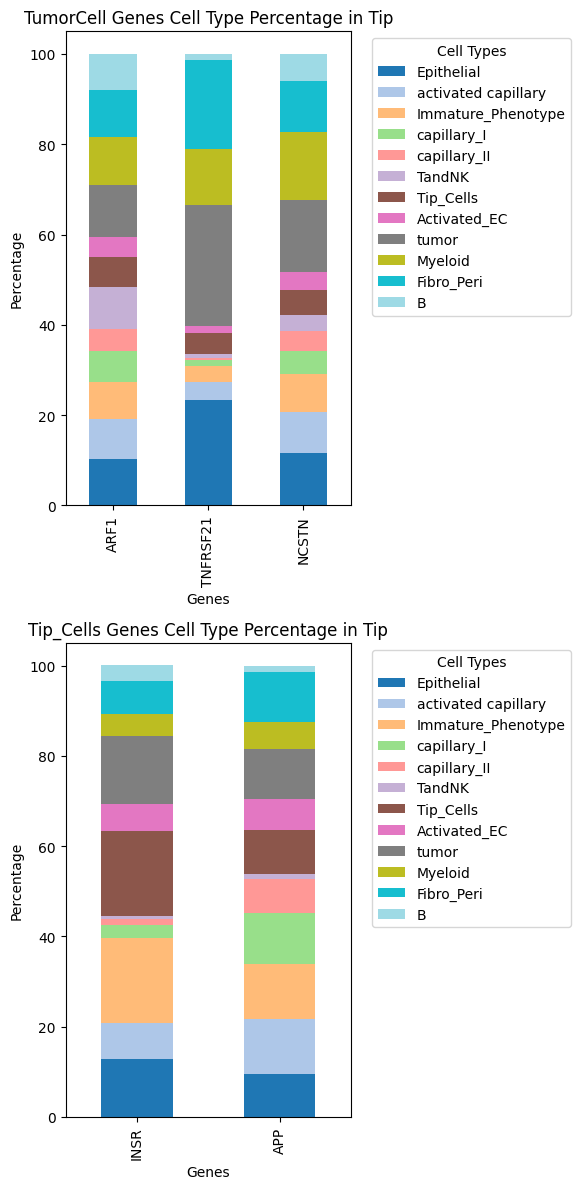

In [60]:
# 데이터프레임 필터링
top_10_tumor_df_tip = tumor_cell_type_percentage_df.loc[top_10_genes_tumor_tip]
top_10_tip_cells_df_tip = tip_cell_type_percentage_df.loc[top_10_genes_tip_cells]

# 그래프 설정
fig, axes = plt.subplots(2, 1, figsize=(6, 12))

# TumorCell 유전자 세포 유형 비율 그래프
top_10_tumor_df_tip.plot(kind='bar', stacked=True, ax=axes[0], colormap='tab20')
axes[0].set_title('TumorCell Genes Cell Type Percentage in Tip')
axes[0].set_ylabel('Percentage')
axes[0].set_xlabel('Genes')
axes[0].legend(title='Cell Types', bbox_to_anchor=(1.05, 1), loc='upper left')

# Tip_Cells 유전자 세포 유형 비율 그래프
top_10_tip_cells_df_tip.plot(kind='bar', stacked=True, ax=axes[1], colormap='tab20')
axes[1].set_title('Tip_Cells Genes Cell Type Percentage in Tip')
axes[1].set_ylabel('Percentage')
axes[1].set_xlabel('Genes')
axes[1].legend(title='Cell Types', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


In [61]:
### NCA 유전자를 발현하는 세포 추출하여 세포 유형의 비율 확인

# 전체 cell type 리스트 추출
cell_types = adata_NCA.obs['anno_cat'].unique()

# TumorCell 컬럼의 유전자 리스트 추출
tumor_genes_tip = list(common_pair['TumorCell'].unique())
tip_genes_tip = list(common_pair['Tip_Cells'].unique())

# 유전자에 대한 세포 유형 비율 계산
tumor_cell_type_percentage_df_tip = calculate_exp_cell_type_percentage(tumor_genes_tip, adata_NCA, cell_types, 'anno_cat')
tip_cell_type_percentage_df_tip = calculate_exp_cell_type_percentage(tip_genes_tip, adata_NCA, cell_types, 'anno_cat')

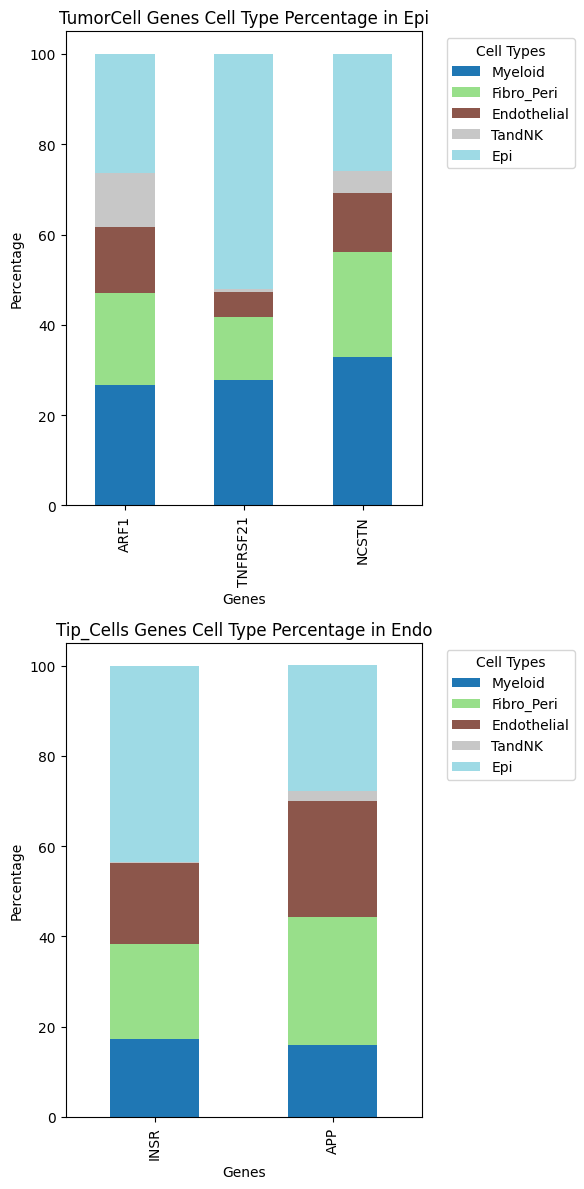

In [65]:
### NCA 유전자를 발현하는 세포 추출하여 세포 유형의 비율 확인 그림

# 상위 10개 유전자 선택
top_10_genes_tumor_tip = tumor_cell_type_percentage_df_tip.sum(axis=1).head(10).index
top_10_genes_tip = tip_cell_type_percentage_df_tip.sum(axis=1).head(10).index

# 데이터프레임 필터링
top_10_tumor_df_tip = tumor_cell_type_percentage_df_tip.loc[top_10_genes_tumor_tip]
top_10_tip_df_tip = tip_cell_type_percentage_df_tip.loc[top_10_genes_tip]

# 그래프 설정
fig, axes = plt.subplots(2, 1, figsize=(6, 12))

# TumorCell 유전자 세포 유형 비율 그래프
top_10_tumor_df_tip.plot(kind='bar', stacked=True, ax=axes[0], colormap='tab20')
axes[0].set_title('TumorCell Genes Cell Type Percentage in Epi')
axes[0].set_ylabel('Percentage')
axes[0].set_xlabel('Genes')
axes[0].legend(title='Cell Types', bbox_to_anchor=(1.05, 1), loc='upper left')

# Tip_Cells 유전자 세포 유형 비율 그래프
top_10_tip_df_tip.plot(kind='bar', stacked=True, ax=axes[1], colormap='tab20')
axes[1].set_title('Tip_Cells Genes Cell Type Percentage in Endo')
axes[1].set_ylabel('Percentage')
axes[1].set_xlabel('Genes')
axes[1].legend(title='Cell Types', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

## 이전방법

In [126]:
# load data
# CCI_res031 상위 100개 유전자
# CCI_res032 상위 200개 유전자

path = '/home/nccpml/DATA2/hanbyeol/TEC/CCI_res09/'

dfs = {}
file_list = [f for f in os.listdir(path) 
            if f.startswith("gcam_") and f.endswith(".csv")]

for file in file_list:
    key = file.split("gcam_")[1].split("_res")[0]  # 'gcam_' 이후와 '._res' 이전의 문자열 추출
    df = pd.read_csv(path + file)
    dfs[key] = df

In [128]:
# 카운트로 정렬 후 Normalized_Weight로 정렬 
tmp1 = dfs['Tip_Cells'].sort_values(by='Count', ascending=False).head(100)
Tip_Cells = tmp1.sort_values(by='Mean Normalized_Weight', ascending=False).head(100)
Tip_Cells

,TumorCell,Tip_Cells,Mean Normalized_Weight,Variance Normalized_Weight,Std Dev Normalized_Weight,Median Normalized_Weight,CV Normalized_Weight,Count
20,SORBS1,INSR,0.946254,0.011415,0.106842,1.000000,11.291005,10
19,AHSG,INSR,0.930529,0.010570,0.102812,0.971486,11.048790,10
18,RELN,LRP8,0.913808,0.010509,0.102514,0.963123,11.218329,10
58,LRPAP1,LRP8,0.913108,0.004542,0.067396,0.926928,7.380925,9
59,TAC4,TACR1,0.891795,0.003130,0.055943,0.890395,6.273035,9
...,...,...,...,...,...,...,...,...
80,COL4A6,CD93,0.557034,0.003990,0.063169,0.573995,11.340192,8
96,CD86,CTLA4,0.555546,0.005991,0.077402,0.574271,13.932658,7
81,APP,PTGER2,0.550250,0.004924,0.070174,0.577642,12.753056,8
70,TDGF1,ACVR1C,0.547613,0.003592,0.059932,0.568361,10.944154,8


In [168]:
# 발현값이 0이 아닌 유전자 목록을 추출합니다
non_zero_genes = adata_gs_Tip_Cells.to_df().sum()[adata_gs_Tip_Cells.to_df().sum() != 0].index.tolist()

# TEC 데이터프레임에서 TumorCell 열에 있는 유전자가 non_zero_genes에 포함된 행만 필터링합니다
tmp = Tip_Cells[Tip_Cells['Tip_Cells'].isin(non_zero_genes)]
Tip_Cells = tmp[tmp['TumorCell'].isin(non_zero_genes)]

# 필터링된 데이터프레임 출력
Tip_Cells = Tip_Cells.reset_index(drop=True)
Tip_Cells.head(10)

,TumorCell,Tip_Cells,Mean Normalized_Weight,Variance Normalized_Weight,Std Dev Normalized_Weight,Median Normalized_Weight,CV Normalized_Weight,Count
0,SORBS1,INSR,0.946254,0.011415,0.106842,1.000000,11.291005,10
1,RELN,LRP8,0.913808,0.010509,0.102514,0.963123,11.218329,10
2,LRPAP1,LRP8,0.913108,0.004542,0.067396,0.926928,7.380925,9
3,TAC4,TACR1,0.891795,0.003130,0.055943,0.890395,6.273035,9
4,ARF1,INSR,0.873440,0.007330,0.085617,0.890554,9.802325,10
5,GP6,COL4A3,0.831817,0.005909,0.076869,0.824020,9.241096,8
6,GP6,COL4A2,0.825877,0.006356,0.079724,0.816665,9.653309,8
7,GP6,COL4A1,0.788179,0.004852,0.069658,0.790360,8.837876,8
8,LAT,SYK,0.784056,0.005496,0.074135,0.781243,9.455338,10
9,ITGA2,COL6A5,0.776248,0.002716,0.052120,0.791528,6.714345,9


In [152]:
# 특정 값이 리스트에 있는지 확인
value_to_check = "STAB2"
if value_to_check in non_zero_genes:
    print(f"{value_to_check} is in the list")
else:
    print(f"{value_to_check} is not in the list")

STAB2 is in the list


In [147]:
Tip_Cells_tumor_geneset

['TAC4',
 'RELN',
 'ADCY7',
 'ITGA1',
 'TIE1',
 'DDR1',
 'COL13A1',
 'COL4A3',
 'GP1BA',
 'CD86',
 'ITGB2',
 'FGFR1',
 'LILRB2',
 'CNR1',
 'SELP',
 'LRPAP1',
 'ADM',
 'HRAS',
 'ITGB3',
 'TNFRSF11B',
 'TEK',
 'STAB2',
 'LAT',
 'RPSA',
 'IGF2',
 'GP6',
 'GP9',
 'SIRPA',
 'EGFR',
 'TSHR',
 'CD44',
 'ITGA2',
 'CALM1',
 'SORBS1',
 'ITGA11',
 'SDC1',
 'VIP',
 'CD3G',
 'ITGB1',
 'RACK1',
 'APP',
 'ARF1',
 'ITGAM',
 'ITGA10',
 'F12']

In [131]:
Tip_Cells_tumor_geneset = Tip_Cells['TumorCell'].tolist()
Tip_Cells_tumor_geneset = list(set(Tip_Cells_tumor_geneset))
Tip_Cells_geneset = Tip_Cells['Tip_Cells'].tolist()
Tip_Cells_geneset = list(set(Tip_Cells_geneset))

In [145]:
for gene in Tip_Cells_tumor_geneset:
    print(f"{gene}: {adata_gs_tumor.to_df()[gene].sum()}")

print(len(Tip_Cells_tumor_geneset))

TAC4: 31.763080596923828
RELN: 2.4940667152404785
ADCY7: 56.24870300292969
ITGA1: 98.06460571289062
TIE1: 2.543095827102661
DDR1: 483.135498046875
COL13A1: 8.545530319213867
COL4A3: 133.42506408691406
GP1BA: 3.4376258850097656
CD86: 22.218379974365234
ITGB2: 173.89451599121094
FGFR1: 66.16529846191406
LILRB2: 2.799717426300049
CNR1: 5.792452812194824
SELP: 0.5870054960250854
LRPAP1: 573.1060791015625
ADM: 223.76589965820312
HRAS: 202.82666015625
ITGB3: 12.1261568069458
TNFRSF11B: 18.039751052856445
TEK: 1.2484780550003052
STAB2: 0.0
LAT: 31.83863067626953
RPSA: 2107.72802734375
IGF2: 66.00102996826172
GP6: 3.0656418800354004
GP9: 3.0751864910125732
SIRPA: 34.25025177001953
EGFR: 355.7984619140625
TSHR: 0.0
CD44: 559.008544921875
ITGA2: 278.8961486816406
CALM1: 1644.1676025390625
SORBS1: 42.05267333984375
ITGA11: 0.9280428290367126
SDC1: 659.5999755859375
VIP: 0.5924465656280518
CD3G: 44.56570816040039
ITGB1: 746.1672973632812
RACK1: 2300.13623046875
APP: 844.8216552734375
ARF1: 1185.87

In [146]:
for gene in Tip_Cells_geneset:
    print(f"{gene}: {adata_gs_Tip_Cells.to_df()[gene].sum()}")
    
print(len(Tip_Cells_geneset))

LAMA3: 11.057124137878418
COL4A1: 1436.73779296875
COL4A2: 1215.205810546875
VWF: 1551.2581787109375
PKM: 567.893310546875
LAMC3: 7.151813507080078
COL6A1: 104.76765441894531
LAMA4: 558.978759765625
COL4A3: 2.7139203548431396
COL2A1: 2.031682014465332
ANGPT2: 763.6697998046875
COL6A3: 19.798368453979492
CTLA4: 8.713127136230469
LRP8: 15.289715766906738
HSPG2: 1232.275634765625
TLN1: 309.92742919921875
COL4A5: 8.189508438110352
COL6A5: 2.218614101409912
FGF14: 2.2732386589050293
LAMB1: 312.9258117675781
COL5A2: 53.02064514160156
INSR: 982.8104248046875
GNAI2: 922.1942138671875
COL6A6: 0.2854004204273224
COL9A2: 1.62301504611969
HLA-C: 2102.5927734375
COL1A2: 54.492679595947266
CD93: 1090.904296875
RAMP2: 1375.9051513671875
PTGER2: 0.23933900892734528
F10: 5.346032619476318
TACR1: 17.355602264404297
COL9A3: 7.501163482666016
COL1A1: 37.831111907958984
COL9A1: 0.2854004204273224
CALR: 1044.873291015625
SYK: 7.038078784942627
CDH1: 8.705918312072754
COL6A2: 251.9918670654297
AGTRAP: 146.32

## GSEA

In [170]:
# %matplotlib inline
# %config InlineBackend.figure_format='retina' # mac
#%load_ext autoreload
#%autoreload 2
import pandas as pd
import gseapy as gp
import matplotlib.pyplot as plt
import copy, os, time
import numpy as np
import scanpy as sc
import anndata

In [171]:
from gseapy import Biomart
bm = Biomart()


In [172]:
# default: Human
names = gp.get_library_name()
names[:10]

['ARCHS4_Cell-lines',
 'ARCHS4_IDG_Coexp',
 'ARCHS4_Kinases_Coexp',
 'ARCHS4_TFs_Coexp',
 'ARCHS4_Tissues',
 'Achilles_fitness_decrease',
 'Achilles_fitness_increase',
 'Aging_Perturbations_from_GEO_down',
 'Aging_Perturbations_from_GEO_up',
 'Allen_Brain_Atlas_10x_scRNA_2021']